# SET DE PARAMETROS ALEATORIOS

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def generar_tabla(N=100):
    tc = np.random.uniform(0, 1, N)
    phi_c = np.random.uniform(0, 2 * np.pi, N)
    psi = np.random.uniform(0, np.pi, N)                               #editado
    RA = np.random.uniform(0, 2 * np.pi, N)             
    iota = np.arccos(1 - 2 * np.random.uniform(0, 1, N))
    DEC = np.arccos(1 - 2 * np.random.uniform(0, 1, N)) - (np.pi/2)    #editado

    tabla = pd.DataFrame({
        'tc': tc,
        'phi_c': phi_c,
        'psi': psi,
        'RA': RA,
        'iota': iota,
        'DEC': DEC
    })

    return tabla

parametros = generar_tabla(100)
print(parametros)
parametros.to_csv("parametrosgeneradosN100.csv", index=False)

          tc     phi_c       psi        RA      iota       DEC
0   0.843529  4.927343  1.889890  4.631175  1.167705  0.596737
1   0.123122  1.309766  0.637932  6.236011  0.186571 -0.251771
2   0.831745  5.607742  0.947799  4.584580  1.794375  0.887210
3   0.136999  0.223508  2.924520  3.592727  1.113242 -0.886731
4   0.834261  2.384718  1.912581  6.241127  1.039174  1.379832
..       ...       ...       ...       ...       ...       ...
95  0.054232  3.745406  1.861781  2.310293  2.014854  0.023871
96  0.583300  4.007082  1.465991  3.262623  1.428151  0.891187
97  0.585963  5.880177  1.101436  0.436860  0.153964 -0.640419
98  0.305495  5.216752  1.537273  4.267676  2.083031  0.414513
99  0.081458  3.807358  1.418376  0.909497  1.720065 -0.009521

[100 rows x 6 columns]


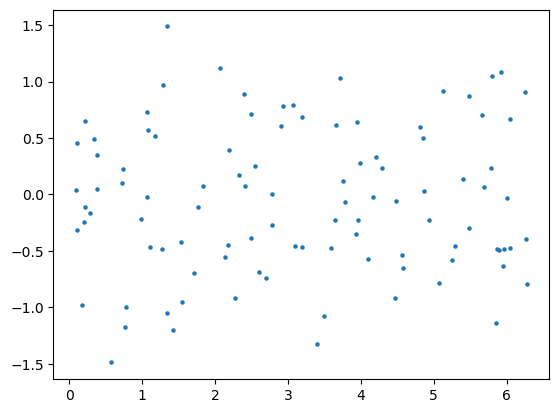

In [13]:
plt.scatter(parametros['RA'], parametros['DEC'], s=5)

# MERGER RATE

C:\Users\juanf\AppData\Local\Temp\ipykernel_23912\3053399466.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, names=column_names)
C:\Users\juanf\AppData\Local\Temp\ipykernel_23912\3053399466.py:28: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  data["dN_dt"] = simps(data["d2N_dzdt"], data["z_merger"])


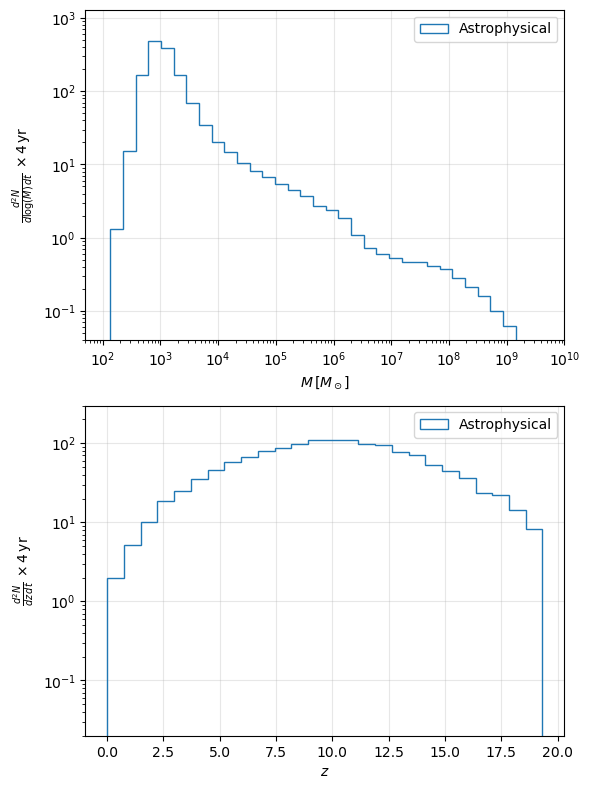

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from scipy import integrate
from scipy.integrate import simps


file_path = "popIII/popIII_K16_extrapolated.dat.bz2"

column_names = ["z_merger", "m1", "m2", "a1", "a2", "alpha", "beta", "gamma", "psi", "afin", "mfin", "vkick", "vesc_halo", "vesc_bar", "Mcluster", "Mdisk_stars", "Mdisk_gas", "Mbulge_stars", "Mbulge_gas", "MNSC", "Mreservoir", "Mhalo_final", "halo_density"]

data = pd.read_csv(file_path, delim_whitespace=True, names=column_names)

#c = 299792  # Velocidad de la luz en km/s
c = 9.72e-15  # Velocidad de la luz en Mpc/s
 

# ------ Se calcula la distancia luminica ------
def luminosity_distance(z):
    return cosmo.luminosity_distance(z).value  # Calcula la distancia luminica con cosmologia basada en Planck 2018 (H0 = 67.4km/s/Mpc , Ωm = 0.315, ΩΛ = 0.685)
    
data["DL"] = data["z_merger"].apply(luminosity_distance)

# ------ Luego se calcula d^2N/dzdt --------
data["d2N_dzdt"] = (4 * np.pi * c * data["halo_density"] * data["DL"]**2 / ((1 + data["z_merger"])**2))

data["dN_dt"] = simps(data["d2N_dzdt"], data["z_merger"])

# ------ Se ordenann los datos para crear los histogramas para las distribuciones ---------
# Histograma de redshift
z_bins = np.linspace(data["z_merger"].min(), data["z_merger"].max(), 27)
#z_hist, z_edges = np.histogram(data["z_merger"], bins=z_bins, weights=data["d2N_dzdt"])

# Histograma de masa total
data["total_mass"] = data["m1"] + data["m2"]
mass_bins = np.logspace(np.log10(data["total_mass"].min()), np.log10(data["total_mass"].max()), 40)
mass_hist, mass_edges = np.histogram(data["total_mass"], bins=mass_bins, weights=data["d2N_dzdt"])


#----- Aplicar gaussiana en z ------
sigma_z = 0.55 
data["z_merger_noisy"] = data["z_merger"] + np.random.normal(0, sigma_z, len(data))

z_hist, z_edges = np.histogram(data["z_merger_noisy"], bins=z_bins, weights=data["d2N_dzdt"])

# ------ Graficar ------
fig, axs = plt.subplots(2, 1, figsize=(6, 8), sharex=False)

axs[0].hist(
    0.5 * (mass_edges[:-1] + mass_edges[1:]), 
    bins=mass_bins,
    weights=mass_hist *3600* 24 * 365 *4,
    histtype='step',
    stacked=True,
    fill=False,
#    color="blue",
    label="Astrophysical"
)
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel(r"$M \, [M_\odot]$")
axs[0].set_ylabel(r"$\frac{d^2N}{d\log(M) \, dt} \, \times 4 \, \text{yr}$")
#axs[0].set_title("Differential merger rate by mass")
axs[0].grid(alpha=0.3)
axs[0].set_ylim(4e-2, 1300)
axs[0].set_xlim(50, 1e10)
axs[0].legend()

axs[1].hist(
    0.5 * (z_edges[:-1] + z_edges[1:]),  
    bins=z_bins,
    weights=z_hist *3600* 24 * 365 * 4,
    histtype='step',
    stacked=True,
    fill=False,
#    color="blue",
    label="Astrophysical"
)
axs[1].set_yscale("log")
axs[1].set_xlabel(r"$z$")
axs[1].set_ylabel(r"$\frac{d^2N}{dz \, dt} \, \times 4 \, \text{yr}$")
#axs[1].set_title("Differential merger rate by redshift")
axs[1].grid(alpha=0.3)
axs[1].set_ylim(0.02, 300)
axs[1].legend()

plt.tight_layout()
plt.show()


In [20]:
total_events = np.sum(z_hist)
print(total_events * 3600* 24 * 365 * 4)

1405.1987622363288


In [21]:
print(data["d2N_dzdt"])

0         4.921604e-09
1         5.679258e-09
2         4.362020e-09
3         1.517043e-09
4         1.438444e-09
              ...     
727876    1.515308e-16
727877    5.969788e-17
727878    1.109368e-16
727879    7.508846e-18
727880    1.002663e-18
Name: d2N_dzdt, Length: 727881, dtype: float64


In [22]:
print(data["dN_dt"])

0         1.731519e-08
1         1.731519e-08
2         1.731519e-08
3         1.731519e-08
4         1.731519e-08
              ...     
727876    1.731519e-08
727877    1.731519e-08
727878    1.731519e-08
727879    1.731519e-08
727880    1.731519e-08
Name: dN_dt, Length: 727881, dtype: float64


In [11]:
print(1.731519e-08 * 3600* 24 * 365 * 4)

2.1842073273600002


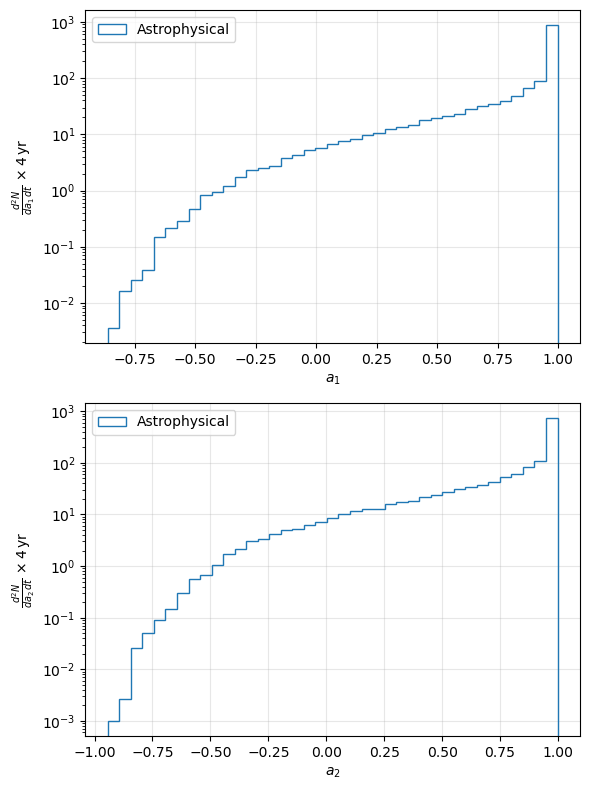

In [23]:
a1_bins = np.linspace(data["a1"].min(), data["a1"].max(), 40)
a1_hist, a1_edges = np.histogram(data["a1"], bins=a1_bins, weights=data["d2N_dzdt"])

a2_bins = np.linspace(data["a2"].min(), data["a2"].max(), 40)
a2_hist, a2_edges = np.histogram(data["a2"], bins=a2_bins, weights=data["d2N_dzdt"])

# ------ Graficar ------
fig, axs = plt.subplots(2, 1, figsize=(6, 8), sharex=False)

axs[0].hist(
    0.5 * (a1_edges[:-1] + a1_edges[1:]), 
    bins=a1_bins,
    weights=a1_hist*3600* 24 * 365 * 4,
    histtype='step',
    stacked=True,
    fill=False,
#    color="blue",
    label="Astrophysical"
)
#axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel(r"$a_1$")
axs[0].set_ylabel(r"$\frac{d^2N}{da_1 \, dt} \, \times 4 \, \text{yr}$")
#axs[0].set_title(r"Differential merger rate by spin parameter $a_1$")
axs[0].grid(alpha=0.3)
axs[0].legend()

axs[1].hist(
    0.5 * (a2_edges[:-1] + a2_edges[1:]),  
    bins=a2_bins,
    weights=a2_hist*3600* 24 * 365 * 4,
    histtype='step',
    stacked=True,
    fill=False,
#    color="blue",
    label="Astrophysical"
)
axs[1].set_yscale("log")
axs[1].set_xlabel(r"$a_2$")
axs[1].set_ylabel(r"$\frac{d^2N}{da_2 \, dt} \, \times 4 \, \text{yr}$")
#axs[1].set_title(r"Differential merger rate by spin parameter $a_2$")
axs[1].grid(alpha=0.3)
#axs[1].set_ylim(0.003, 1000)
axs[1].legend()

plt.tight_layout()
plt.show()


# CATALOGO DE EVENTOS 

In [18]:
import pandas as pd
import numpy as np

time_factor = 3600 * 24 * 365 *4

data["event_probability"] = data["d2N_dzdt"] * time_factor

probabilities = data["event_probability"] / data["event_probability"].sum()  # Normalizar las probabilidades

expected_events = int(data["event_probability"].sum())

print(f"Eventos esperados en 1 año: {expected_events}")

sampled_events = data.sample(n=expected_events, weights=probabilities, replace=True)
selected_columns = ["m1", "m2", "a1", "a2","DL", "z_merger", "alpha", "beta", "gamma", "halo_density","d2N_dzdt"]
sampled_events = sampled_events[selected_columns]

sampled_events.to_csv("popIII/popIII_catalog.csv", index=False)

Eventos esperados en 1 año: 1410


In [19]:
pd.read_csv('popIII/popIII_catalog.csv')

,m1,m2,a1,a2,DL,z_merger,alpha,beta,gamma,halo_density,d2N_dzdt
0,456.064,324.741,0.950583,0.888278,102283.387438,9.69059,0.107898,0.156537,0.094050,4.754550e-06,5.316091e-11
1,416.510,423.268,0.739852,0.367884,197467.257897,17.41690,0.071591,0.149464,0.165201,3.605860e-06,5.063399e-11
2,525.811,516.419,0.810259,0.632073,113602.705513,10.63050,0.079718,0.022368,0.100031,2.432770e-06,2.835031e-11
3,267.063,249.253,0.917275,0.409417,204287.888856,17.95900,0.048470,0.126079,0.077610,7.543960e-07,1.069867e-11
4,330.792,291.663,0.612314,0.884259,161256.947368,14.51770,0.056691,0.097582,0.117241,1.502390e-06,1.981714e-11
...,...,...,...,...,...,...,...,...,...,...,...
1405,522.758,439.492,0.990179,0.990232,118415.840930,11.02790,0.081464,0.045247,0.042263,1.468900e-06,1.739035e-11
1406,5988.800,4488.940,0.994564,0.998000,40018.794499,4.30805,0.039099,0.135330,0.125189,5.488140e-06,3.810301e-11
1407,325.303,186.425,0.940091,0.997159,150750.016891,13.66870,0.169838,0.043352,0.126981,2.645670e-07,3.413055e-12
1408,481.776,393.277,0.997495,0.874657,172953.071700,15.45840,0.205865,0.161342,0.045157,6.077270e-07,8.197209e-12


In [33]:
data["event_probability"].sum()

352.50771888876193

In [35]:
parametros = pd.read_csv("parametrosgeneradosN100.csv")

n_eventos = len(sampled_events)

sampled_events_expanded = pd.DataFrame(np.repeat(sampled_events.values, 100, axis=0), columns=sampled_events.columns)
parametros_expanded = pd.concat([parametros] * n_eventos, ignore_index=True)

if len(sampled_events_expanded) == len(parametros_expanded):
    final_catalog = pd.concat([sampled_events_expanded.reset_index(drop=True), parametros_expanded], axis=1)
    
    final_catalog.to_csv("popIII/popIII_finalcatalog100.csv", index=False)
    print(" Catálogo final generado: popIII_finalcatalog100.csv")
else:
    print(f" Error: Tamaños desiguales - Eventos: {len(sampled_events_expanded)}, Parámetros: {len(parametros_expanded)}")


 Catálogo final generado: popIII_finalcatalog100.csv


In [37]:
pd.read_csv('popIII/popIII_finalcatalog100.csv')

,m1,m2,a1,a2,DL,z_merger,alpha,beta,gamma,halo_density,d2N_dzdt,tc,phi_c,psi,RA,iota,DEC
0,365.024,187.695,0.878282,-0.233032,178821.696180,15.9288,0.129913,0.067334,0.112455,0.000002,2.713876e-11,0.843529,4.927343,1.889890,4.631175,1.167705,0.596737
1,365.024,187.695,0.878282,-0.233032,178821.696180,15.9288,0.129913,0.067334,0.112455,0.000002,2.713876e-11,0.123122,1.309766,0.637932,6.236011,0.186571,-0.251771
2,365.024,187.695,0.878282,-0.233032,178821.696180,15.9288,0.129913,0.067334,0.112455,0.000002,2.713876e-11,0.831745,5.607742,0.947799,4.584580,1.794375,0.887210
3,365.024,187.695,0.878282,-0.233032,178821.696180,15.9288,0.129913,0.067334,0.112455,0.000002,2.713876e-11,0.136999,0.223508,2.924520,3.592727,1.113242,-0.886731
4,365.024,187.695,0.878282,-0.233032,178821.696180,15.9288,0.129913,0.067334,0.112455,0.000002,2.713876e-11,0.834261,2.384718,1.912581,6.241127,1.039174,1.379832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35195,5963.670,322.572,0.996794,0.932666,88427.941083,8.5284,0.189856,0.080341,0.151680,0.000001,1.195996e-11,0.054232,3.745406,1.861781,2.310293,2.014854,0.023871
35196,5963.670,322.572,0.996794,0.932666,88427.941083,8.5284,0.189856,0.080341,0.151680,0.000001,1.195996e-11,0.583300,4.007082,1.465991,3.262623,1.428151,0.891187
35197,5963.670,322.572,0.996794,0.932666,88427.941083,8.5284,0.189856,0.080341,0.151680,0.000001,1.195996e-11,0.585963,5.880177,1.101436,0.436860,0.153964,-0.640419
35198,5963.670,322.572,0.996794,0.932666,88427.941083,8.5284,0.189856,0.080341,0.151680,0.000001,1.195996e-11,0.305495,5.216752,1.537273,4.267676,2.083031,0.414513


In [39]:
df = pd.read_csv("popIII/popIII_finalcatalog100.csv")  

df_splits = np.array_split(df, 4)

# Cada df_splits[i] es un DataFrame con 8800 filas
for i, df_part in enumerate(df_splits):
    df_part.to_csv(f"popIII/popIII_finalcatalogN100_{i+1}.csv", index=False)

C:\Users\juanf\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [19]:
d1 = pd.read_csv('popIII_catalog.csv')
d2 = pd.read_csv('popIII_finalcatalog_detectability30.csv')

In [21]:
d1


,m1,m2,a1,a2,DL,z_merger,alpha,beta,gamma,halo_density,d2N_dzdt
0,1351.600,840.122,0.998000,0.998000,63860.225993,6.42621,0.108405,0.071332,0.143150,0.000010,9.160196e-11
1,437.688,430.642,0.998000,0.942242,135811.746116,12.45440,0.109272,0.061791,0.112684,0.000001,1.362576e-11
2,876.654,427.471,0.998000,0.094659,91596.980814,8.79548,0.078454,0.033711,0.046121,0.000017,1.798737e-10
3,1951.720,341.481,0.998000,0.847475,150710.508131,13.66550,0.102674,0.074238,0.095452,0.000002,2.148846e-11
4,813.383,734.186,0.931712,0.860103,73786.284151,7.28307,0.321014,0.159211,0.163748,0.000125,1.213526e-09
...,...,...,...,...,...,...,...,...,...,...,...
347,925.369,328.680,0.998000,-0.136134,69663.422065,6.92856,0.136494,0.102396,0.062601,0.000005,4.483390e-11
348,9553.830,5688.730,0.998000,0.998000,49759.188193,5.18591,0.186527,0.118120,0.100936,0.000009,6.830846e-11
349,1356.890,1130.740,0.998000,0.998000,98620.371280,9.38468,0.023791,0.173416,0.162767,0.000005,5.237603e-11
350,389.761,353.980,0.919866,0.958603,63916.022423,6.43106,0.047035,0.156825,0.161651,0.000003,2.850767e-11


In [29]:
import pandas as pd

# Cargar el archivo
file_path = "popIII_finalcatalog_detectability30.csv"
df = pd.read_csv(file_path)

# Definir las columnas a eliminar
columns_to_drop = ['tc', 'RA', 'DEC', 'phi_c', 'iota', 'psi']

# Eliminar las columnas innecesarias
df_filtered = df.drop(columns=columns_to_drop)

# Eliminar duplicados basándose en las columnas clave del evento
df_unique = df_filtered.drop_duplicates(subset=['z_merger', 'm1', 'm2', 'a1', 'a2','DL', 'alpha', 'beta', 'gamma'])

# Guardar el nuevo archivo con 352 filas y 9 columnas
output_path = "popIII_finalcatalog_unique.csv"
df_unique.to_csv(output_path, index=False)

print(f"Archivo guardado en: {output_path}")
print(f"Dimensiones finales: {df_unique.shape}")


Archivo guardado en: popIII_finalcatalog_unique.csv
Dimensiones finales: (351, 12)


# MERGER RATE DE EVENTOS DETECTADOS

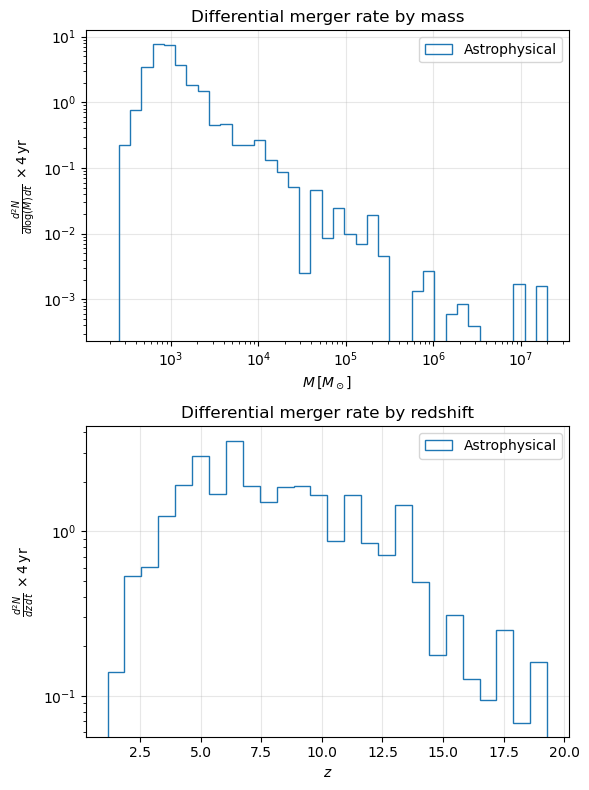

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from scipy import integrate
from scipy.integrate import simps


file_path = "popIII/popIII_catalog.csv"

#column_names = ["z_merger", "m1", "m2", "a1", "a2", "alpha", "beta", "gamma", "halo_density"]

data = pd.read_csv(file_path)

#c = 299792  # Velocidad de la luz en km/s
c = 9.72e-15  # Velocidad de la luz en Mpc/s
 

# ------ Se calcula la distancia luminica ------
#def luminosity_distance(z):
#    return cosmo.luminosity_distance(z).value  # Calcula la distancia luminica con cosmologia basada en Planck 2018 (H0 = 67.4km/s/Mpc , Ωm = 0.315, ΩΛ = 0.685)
    
#data["DL"] = data["z_merger"].apply(luminosity_distance)

# ------ Luego se calcula d^2N/dzdt --------
#data["d2N_dzdt"] = (4 * np.pi * c * data["halo_density"] * data["DL"]**2 / ((1 + data["z_merger"])**2))

#data["dN_dt"] = simps(data["d2N_dzdt"], data["z_merger"])

# ------ Se ordenann los datos para crear los histogramas para las distribuciones ---------
# Histograma de redshift
z_bins = np.linspace(data["z_merger"].min(), data["z_merger"].max(), 27)
#z_hist, z_edges = np.histogram(data["z_merger"], bins=z_bins, weights=data["d2N_dzdt"])

# Histograma de masa total
data["total_mass"] = data["m1"] + data["m2"]
mass_bins = np.logspace(np.log10(data["total_mass"].min()), np.log10(data["total_mass"].max()), 40)
mass_hist, mass_edges = np.histogram(data["total_mass"], bins=mass_bins, weights=data["d2N_dzdt"])


#----- Aplicar gaussiana en z ------
sigma_z = 0.55 
data["z_merger_noisy"] = data["z_merger"] + np.random.normal(0, sigma_z, len(data))

z_hist, z_edges = np.histogram(data["z_merger_noisy"], bins=z_bins, weights=data["d2N_dzdt"])

# ------ Graficar ------
fig, axs = plt.subplots(2, 1, figsize=(6, 8), sharex=False)

axs[0].hist(
    0.5 * (mass_edges[:-1] + mass_edges[1:]), 
    bins=mass_bins,
    weights=mass_hist *3600* 24 * 365 *4,
    histtype='step',
    stacked=True,
    fill=False,
#    color="blue",
    label="Astrophysical"
)
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel(r"$M \, [M_\odot]$")
axs[0].set_ylabel(r"$\frac{d^2N}{d\log(M) \, dt} \, \times 4 \, \text{yr}$")
axs[0].set_title("Differential merger rate by mass")
axs[0].grid(alpha=0.3)
#axs[0].set_ylim(4e-2, 1300)
#axs[0].set_xlim(100, 12e8)
axs[0].legend()

axs[1].hist(
    0.5 * (z_edges[:-1] + z_edges[1:]),  
    bins=z_bins,
    weights=z_hist *3600* 24 * 365 * 4,
    histtype='step',
    stacked=True,
    fill=False,
#    color="blue",
    label="Astrophysical"
)
axs[1].set_yscale("log")
axs[1].set_xlabel(r"$z$")
axs[1].set_ylabel(r"$\frac{d^2N}{dz \, dt} \, \times 4 \, \text{yr}$")
axs[1].set_title("Differential merger rate by redshift")
axs[1].grid(alpha=0.3)
#axs[1].set_ylim(0.02, 300)
axs[1].legend()

plt.tight_layout()
plt.show()
